In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [4]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [5]:
# ResNet 모델 정의
resnet = torchvision.models.resnet18(pretrained=False)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet.to(device)

# 손실 함수 및 최적화 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)

c:\Users\seongjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\seongjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# 모델 학습
num_epochs = 15

for epoch in range(num_epochs):
    running_loss = 0.0
    resnet.train()
    
    for i, (inputs , labels) in enumerate(trainloader):
        inputs , labels  	= inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs , labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

print("학습 완료")

Epoch 1, Loss: 0.12086898094939956
Epoch 2, Loss: 0.042576252561362174
Epoch 3, Loss: 0.02730834193024804
Epoch 4, Loss: 0.020467622156219202
Epoch 5, Loss: 0.01504522806221457
Epoch 6, Loss: 0.012666381344981758
Epoch 7, Loss: 0.010584378622053322
Epoch 8, Loss: 0.00714765000304633
Epoch 9, Loss: 0.0056943461007015125
Epoch 10, Loss: 0.007414265622289712
Epoch 11, Loss: 0.005470420901685317
Epoch 12, Loss: 0.003378321680437265
Epoch 13, Loss: 0.004070920826384892
Epoch 14, Loss: 0.004454962564223548
Epoch 15, Loss: 0.0048285542449166274
학습 완료


In [7]:
# 모델 평가
correct = 0
total = 0
resnet.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"테스트 데이터셋 정확도: {100 * correct / total}%")

테스트 데이터셋 정확도: 99.34%


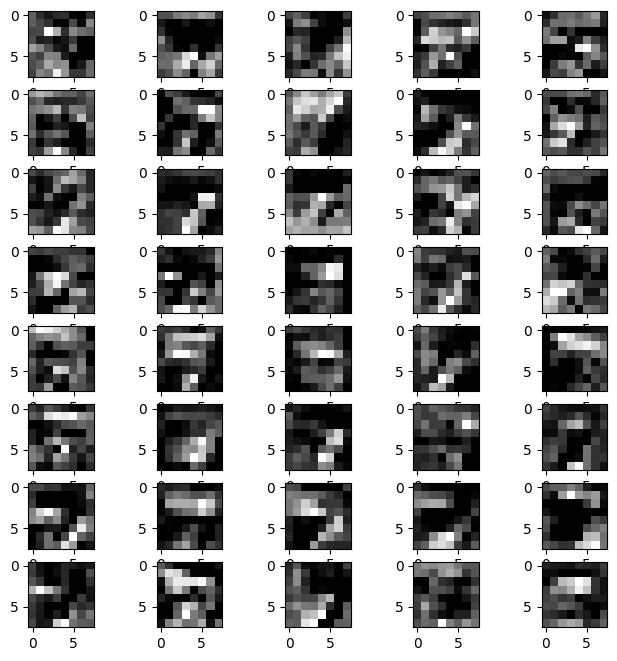

In [17]:
import matplotlib.pyplot as plt

 

dataiter = enumerate(testloader)
_, (images, labels) = next(dataiter)

# 첫 번째 이미지 선택
image = images[0]

# 배치 차원 추가
image = image.unsqueeze(0)

# 이미지를 디바이스로 이동
if torch.cuda.is_available():
    image = image.to(device)

x = image

for name, layer in resnet.named_children():
    x = layer(x)
    if name == 'layer1':
        break

feature_maps = x.detach().cpu().numpy()

fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 8

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(feature_maps[0][i-1], cmap='gray')
plt.show()

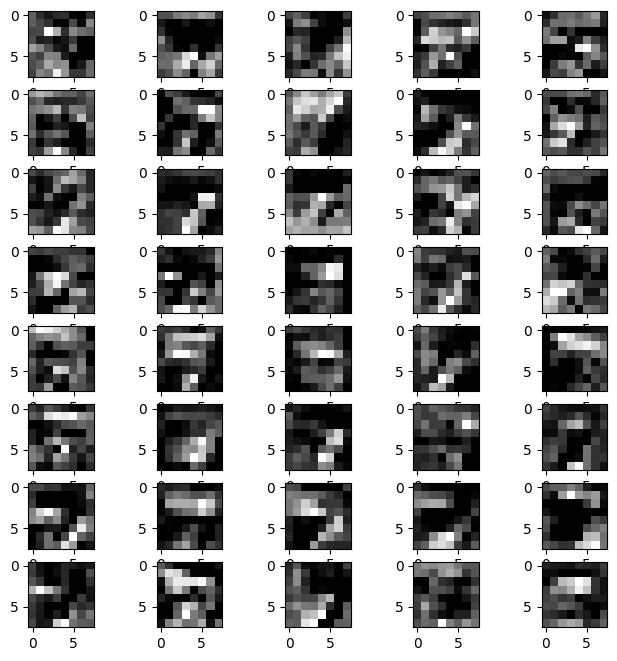

In [18]:
import cv2
import numpy as np

# ...

feature_maps = x.detach().cpu().numpy()

fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 8
 
M = np.float32([[1, 0, 20], [0, 1, 0]])

for i in range(1, columns*rows +1):
    img = feature_maps[0][i-1]
 
    img_moved = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
 
    ghost_img = cv2.addWeighted(img.astype(np.float32), 0.5,
                                img_moved.astype(np.float32), 0.5,
                                0)

    fig.add_subplot(rows, columns, i)
    plt.imshow(ghost_img , cmap='gray')
plt.show()


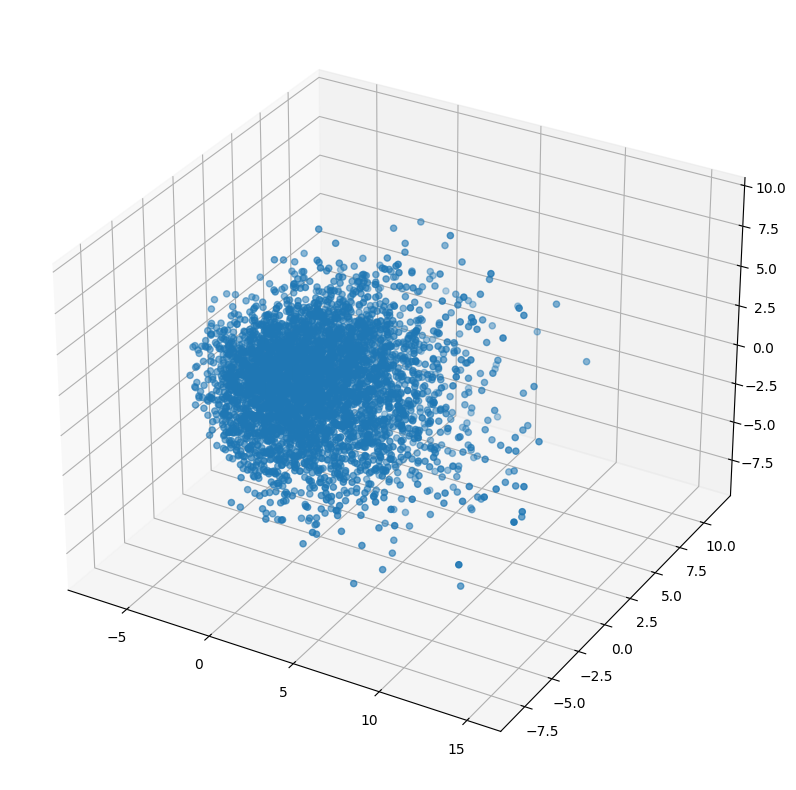

In [10]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


dataiter = enumerate(testloader)
_, (images, labels) = next(dataiter)


if torch.cuda.is_available():
    images = images.to(device)

feature_maps_list = []
resnet.eval()
with torch.no_grad():
    for i, image in enumerate(images):
        image = image.unsqueeze(0)
        x = image
        for name, layer in resnet.named_children():
            x = layer(x)
            if name == 'layer1':
                feature_maps_list.append(x.squeeze().cpu().numpy())
                break

feature_maps_all_images = np.concatenate(feature_maps_list)


feature_maps_all_images_reshaped = feature_maps_all_images.reshape((feature_maps_all_images.shape[0], -1))

# PCA 객체
pca = PCA(n_components=3)

pca_result = pca.fit_transform(feature_maps_all_images_reshaped)

# 결과
fig=plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2])
plt.show()

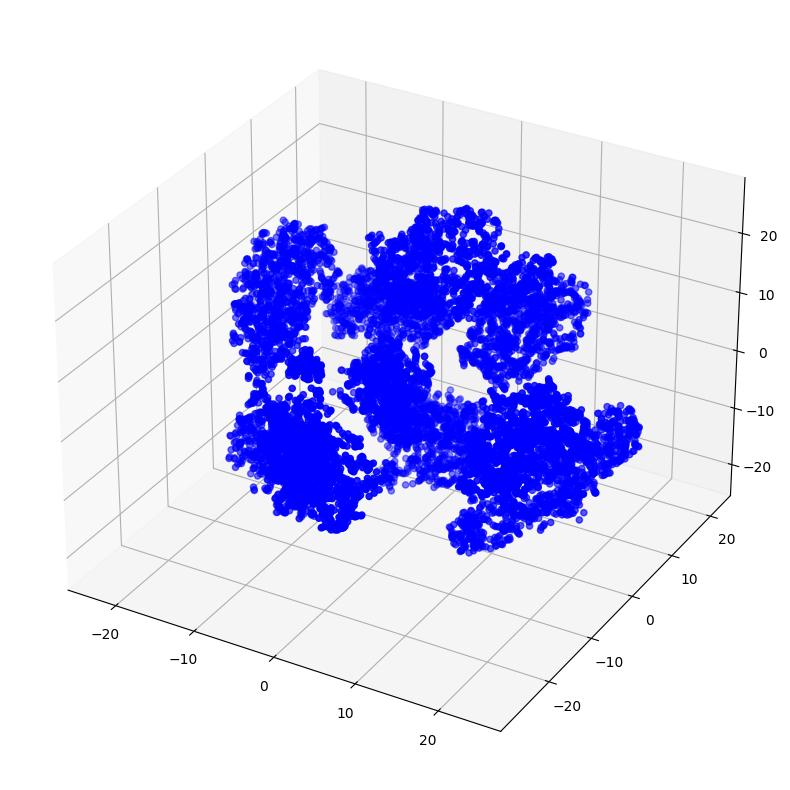

In [11]:
from sklearn.manifold import TSNE

import numpy as np

feature_maps_last_layer = []

# 데이터셋 전체에 대해
for i, (inputs , labels) in enumerate(testloader):
    inputs = inputs.to(device)

    x = inputs
    for name, layer in resnet.named_children():
        if name == 'layer4':   
            x = layer(x)
            feature_maps_last_layer.append(x.detach().cpu().numpy())
            break
        else:
            x = layer(x)

feature_maps_last_layer_reshaped = np.concatenate(feature_maps_last_layer)
feature_map_shape = feature_maps_last_layer_reshaped.shape[1:]
feature_maps_last_layer_reshaped = feature_maps_last_layer_reshaped.reshape(-1, np.product(feature_map_shape))

# t-SNE 객체 생성
tsne = TSNE(n_components=3)

# 모든 특징 맵에 대해 t-SNE를 수행
tsne_result = tsne.fit_transform(feature_maps_last_layer_reshaped)

# 결과 시각화
fig=plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(tsne_result[:,0], tsne_result[:,1], tsne_result[:,2], color='b')
plt.show()